# Hands-on Segmentation of Histological Sections in the BigBrain
## OHBM 2019 Educational Course: Deep Learning for Human Brain Mapping

Hannah Spitzer <br>
Forschungszentrum Jülich <br>
**Email** h.spitzer@fz-juelich.de

# Set up Notebook & download data
All data necessary for execution of this notebook is available from `https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download`. This contains 
- Whole-slide test sections
- Precomputed train and val datasets (calculated with `create-datasets.ipynb`)
- Trained segmentation models

In [1]:
import keras
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Concatenate, Cropping2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import imageio
import os
import re
import glob
from tqdm import tqdm
import pickle
from receptive_field import calculate_receptive_field, suggest_input_sizes

%matplotlib notebook

Using TensorFlow backend.


## Download train, val, and test data 
prepared with `create-datasets.ipynb` notebook

In [2]:
data_dir = 'data'

data_url = 'https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download'
data_archive = os.path.join(data_dir, 'data.zip')
!mkdir -p {data_dir}
!wget -nc {data_url} -O {data_archive}
!unzip -uo {data_archive} -d . 

--2019-06-03 15:08:00--  https://fz-juelich.sciebo.de/s/tFG1H8bAJfyok3E/download
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving fz-juelich.sciebo.de (fz-juelich.sciebo.de)... 132.252.183.1
Connecting to fz-juelich.sciebo.de (fz-juelich.sciebo.de)|132.252.183.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/data.zip’

data/data.zip           [    <=>             ] 376.87M  60.8MB/s    in 8.5s    

2019-06-03 15:08:08 (44.5 MB/s) - ‘data/data.zip’ saved [395179821]

Archive:  data/data.zip
   creating: ./data/precomputed_models/
 extracting: ./data/precomputed_models/model_gmwm.hdf5  
 extracting: ./data/precomputed_models/model_gmwm.pickle  
 extracting: ./data/precomputed_models/model_gmwm_prediction.png  
 extracting: ./data/precomputed_models/model_v1.hdf5  
 extracting: ./data/precomputed_models/model_v1.pickle  
 extracting: ./data/precomputed_models/model_v1_epoch20.hdf5  
 extracting: 

- `data/test` contains whole slide sections, and corresponding labels
- `data/train_*.npz` and `data/val_*.npz` are precomputed datasets of images and labels for training a CNN 
- `data/precomputed_models` contains trained weights of all models that we are going to train in this tutorial

In [3]:
# look at structure of data directory
!ls -R {data_dir} --ignore raw

# define paths to test images
sections_fname = os.path.join(data_dir, 'test/B20_{}.png')
masks_v1_fname = os.path.join(data_dir, 'test/B20_{}_v1.png')
masks_gmwm_fname = os.path.join(data_dir, 'test/B20_{}_gmwm.png')

# get section numbers for test images
def get_section_no(name):
    """return last four digit number in the string `name`"""
    if isinstance(name, list):
        res = []
        for n in name:
            res.append(get_section_no(n))
        return res
    else:
        return re.findall(r'\d\d\d\d', name)[-1]

imgs = sorted(glob.glob(masks_v1_fname.format('*')))
test_sections = get_section_no(imgs)
print('Test sections', test_sections)

data:
data.zip	    train_gmwm.npz    val_gmwm.npz
precomputed_models  train_v1gmwm.npz  val_v1gmwm.npz
test		    train_v1.npz      val_v1.npz

data/precomputed_models:
model_gmwm.hdf5			     model_v1gmwm_epoch20.pickle
model_gmwm.pickle		     model_v1gmwm_epoch20_prediction.png
model_gmwm_prediction.png	     model_v1gmwm_epoch60.hdf5
model_v1_epoch20.hdf5		     model_v1gmwm_epoch60.pickle
model_v1_epoch60.hdf5		     model_v1gmwm_epoch60_prediction.png
model_v1gmwm_epoch10.hdf5	     model_v1.hdf5
model_v1gmwm_epoch10.pickle	     model_v1.pickle
model_v1gmwm_epoch10_prediction.png  model_v1_prediction.png
model_v1gmwm_epoch20.hdf5

data/test:
B20_0361_gmwm.png  B20_0721_v1.png    B20_1441.png	 B20_2161_gmwm.png
B20_0361.png	   B20_1081_gmwm.png  B20_1441_v1.png	 B20_2161.png
B20_0361_v1.png    B20_1081.png       B20_1801_gmwm.png  B20_2161_v1.png
B20_0721_gmwm.png  B20_1081_v1.png    B20_1801.png
B20_0721.png	   B20_1441_gmwm.png  B20_1801_v1.png
Test sections ['0361', '0721', '1081', '1

## Examine images and labels
The aim of this tutorial is to train CNNs for segmenting histological sections. First, we will consider gray/white matter segmentation. Second, we will try to extend the models to segment area V1 (primary visual cortex).

- **Input** (``data/test/B20_0000.png``): histological sections at 20um resolution from the BigBrain (Amunts, 2013)
    - available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/2D_Final_Sections/Coronal/Png/Full_Resolution``
    - images contain gray values between 0 and 255 (8 bit)
    
- **Desired Output (1)** (``data/test/B20_0000_gmwm``): segmentation of the input in 3 classs: gray matter, white matter, and background
    - groundtruth labels based on labeled volume of the BigBrain available from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/3D_Classified_Volumes/Histological_Space/full_cls_100um.nii.gz``
    - slicing of the volume provided by Christian Schiffer (c.schiffer@fz-juelich.de)
    - label images encode background with 0, gray matter with 128, white matter with 255
    - label images are low-resolution (200um)
    
- **Desired Output (2)** (``data/test/B20_0000_v1``): segmentation of the input in 2 classes: V1, background
    - groundtruth labels available in HBP Knowledge Graph from ``https://www.humanbrainproject.eu/en/explore-the-brain/search/?facet_type[0]=Dataset#Dataset/87c6dea7-bdf7-4049-9975-6a9925df393f`` (DOI: 10.25493/3GSV-T4A)
    - label images encode background with 0, V1 with 255
    


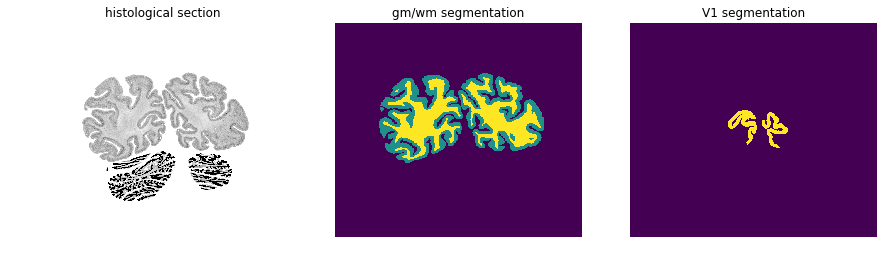

In [4]:
#load and display section and label
img = imageio.imread(sections_fname.format('1081'))
mask_v1 = imageio.imread(masks_v1_fname.format('1081'))
mask_gmwm = imageio.imread(masks_gmwm_fname.format('1081'))

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("histological section")
axes[1].imshow(mask_gmwm)
axes[1].set_title("gm/wm segmentation")
axes[2].imshow(mask_v1)
axes[2].set_title("V1 segmentation")
for ax in axes:
    ax.axis("off")

# Gray/white matter segmentation

## Prepare data for training

In [5]:
print('Size of histological section:', img.shape, '({:.2f} MB)'.format(img.size/1024/1024))

Size of histological section: (5711, 6572) (35.79 MB)


**Challenge**: Histological sections are too large to process at once during training:
- GPU memory too small,
- Effective number of training samples too low

**Solution**: Crop small patches from input images and use for training

*Choices for patch sampling*:
- How large should the input be?
    - Trade-off between efficiency (shared computations for convolutions for large inputs) and variability of data (many small inputs show more different data than one large input)
    - Input patches need to show relevant context
    - Minimal input size may be limited by choice of network architecture (receptivel field - more on that later!)
    - Here, patch size of 268x268px is chosen. 268x268px at 20um per pixel shows 5x5mm of tissue. Sufficient for gray/white matter segmentation
- How many patches should be sampled?
    - As many as possible! Here, patches are computed beforehand (reproducible and faster), but random sampling during training is also possible and increases the variability of the training data
- Where should the patches be sampled from?
    - From the interesting parts of the image!
    - E.g., higher sampling rate from cortex and white matter than background might be beneficial
    - Here, patches were sampled such that each class is represented evenly in the dataset (possible improvement: sample less patches from background class, because it is very easy to learn)
    
For this course, train and val datasets of randomly cropped patches were prepared in advance. If your are interested in how this is done, have a look at `create-datasets.ipynb`

In [6]:
def load_dataset(dataset, data_dir=data_dir):
    res = np.load(os.path.join(data_dir, dataset))
    X = res['X']
    Y = res['Y']
    res.close()
    return X, Y

# load precomputed train and val patches
X_train, Y_train = load_dataset('train_gmwm.npz')
X_val, Y_val = load_dataset('val_gmwm.npz')

Train dataset shape (n_samples, height, width, n_channels): (500, 268, 268, 1)
Val dataset shape (n_samples, height, width, n_channels): (20, 268, 268, 1)


Text(0.5, 0.98, 'Example val patches')

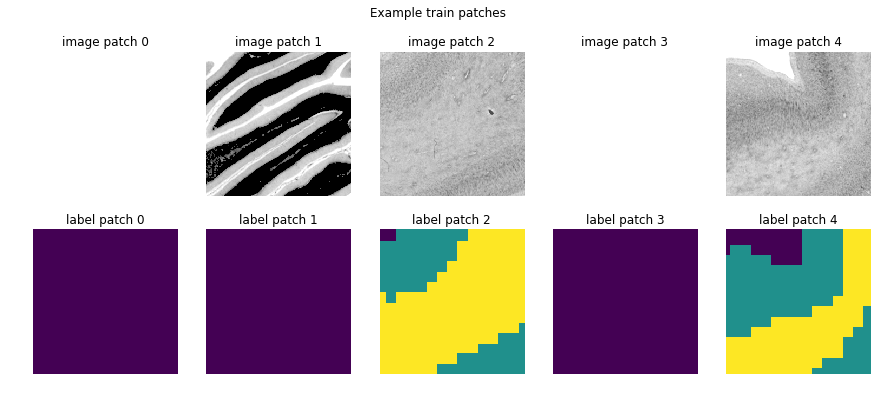

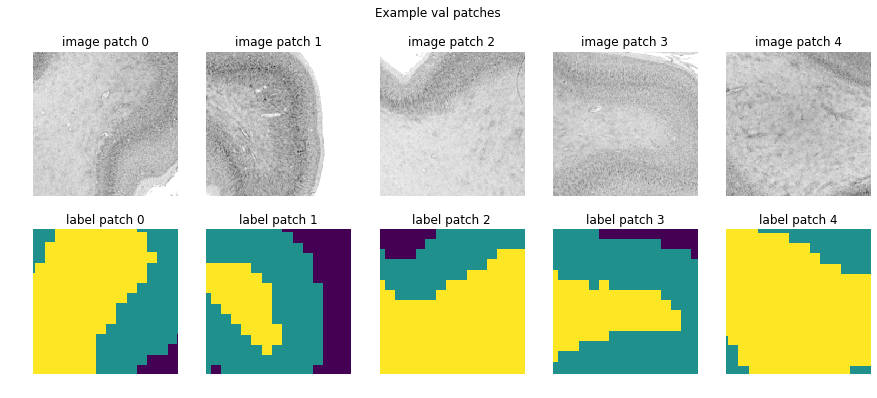

In [7]:
def plot_dataset(X, Y, num=5, vmin_x=0, vmax_x=255, vmax_y=2):
    """Visualize num examples from images X and labels Y"""
    fig, axes = plt.subplots(2,num, figsize=(15,6))
    for i,ax in enumerate(axes[0]):
        ax.imshow(X[i,:,:,0], cmap='gray', vmin=vmin_x, vmax=vmax_x)
        ax.axis('off')
        ax.set_title('image patch {}'.format(i))
    for i,ax in enumerate(axes[1]):
        ax.imshow(Y[i,:,:,0], vmin=0, vmax=vmax_y)
        ax.axis('off')
        ax.set_title('label patch {}'.format(i))
    return fig

print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

# visualize image and label patches
fig = plot_dataset(X_train, Y_train)
fig.suptitle("Example train patches")

fig = plot_dataset(X_val, Y_val)
fig.suptitle("Example val patches")

## U-Net architecture for image segmentation
- Neural network for segmentation of large images should be memory-efficient, to enable training with large batch sizes
- U-Net is good choice for segmentation (Ronneberger, 2015)
    - Fully-convolutional, allows tiled prediction of very large images
    - Downsampling branch consisting of blocks of two convolutions and a pooling layer
    - Upsampling branch consisting of an upsampling layer and two convolutions
    - Skip connections copy activations from downsampling branchs and concatenate with upsampling branch
    
<img src="files/imgs/u-net-architecture.png" style="width:600px">
<div align="right" style="color:gray;">Figure from (Ronneberger, 2015)</div>

*Choices for design of custom U-Net*:
- How many blocks? How many convolutions per block? What filter size? Etc...
    - Original U-net architecture is a good starting point, but might not be optimal
    - Try different depths, filter sizes, etc.
   

**Important: Use valid convolutions!**
<table>
    <tr>
        <td><div align="center">Valid convolution</div> </td>
        <td><div align="center">Convolution with padding</div> </td>
    </tr>
    <tr>
        <td> <img src="http://deeplearning.net/software/theano/_images/no_padding_no_strides.gif" alt="Valid Convolution" style="width: 250px;"/> </td>
        <td> <img src="http://deeplearning.net/software/theano/_images/same_padding_no_strides_transposed.gif" alt="Convolution with padding" style="width: 250px;"/> </td>
    </tr>
</table>
<div align="right" style="color:gray;">Figures from http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html</div>

- Otherwise, predictions at the borders of the image patches are not correct. This is a problem, when doing tiled prediction of large images
- This results in a smaller output size than input size
- Groundtruth labels need to be cropped to the smaller output size when calculating performance metrics


In [8]:
# functions needed for U-net definition
def crop_to_shape_tensor(input_tensor, template_tensor):
    """Crop `input_tensor` to the shape of `template_tensor` by applying a Cropping2D layer.
    Throw ValueError if `template_tensor` has a larger size than `input_tensor`.
    
    Args:
        input_tensor: Tensor with shape attribute
        template_tensor: Tensor with shape attribute
    Returns:
        cropped Tensor
    """
    from_shape = np.array(input_tensor.shape.as_list()[1:3])
    to_shape = np.array(template_tensor.shape.as_list()[1:3])
    if np.any(to_shape > from_shape):
        raise ValueError("template_tensor is larger than input_tensor with shapes {} and {}".format(to_shape, from_shape))
    # crop from left/top
    crop1 = np.floor((from_shape-to_shape)/2.).astype(int)
    # crop from right/bottom
    crop2 = np.ceil((from_shape-to_shape)/2.).astype(int)
    cropped_tensor = Cropping2D(cropping=((crop1[0], crop2[0]), (crop1[1], crop2[1])))(input_tensor)
    return cropped_tensor

def crop_to_shape(arr, shape):
    """Crop `arr` to have shape `shape`.
    Throw ValueError if `shape` is larger than `arr.shape`
    
    Args:
        arr (np.ndarray): array to crop with shape (., h, w, .)
        shape (tuple): desired shape (h',w')
    """
    from_shape = np.array(arr.shape[1:3])
    to_shape = np.array(shape)
    if np.any(to_shape > from_shape):
        raise ValueError('shape is larger than arr.shape with {} {}'.format(to_shape, from_shape))
    crop = np.floor((from_shape-to_shape)/2.).astype(np.uint8)
    return arr[:,crop[0]:shape[0]+crop[0],crop[1]:shape[1]+crop[1]]
    

### Custom U-Net definition
- 4 downsampling blocks, 4 upsampling blocks
- compared to original U-net, has less filters per block to reduce amount of parameters and memory required when training the model

In [9]:
# U-Net definition
def u_net(input_tensor, num_classes=3):  
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='down1_c1')(input_tensor)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='down1_c2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='down1_p1')(conv1)
 
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down2_c1')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down2_c2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='down2_p1')(conv2)

    conv3 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down3_c1')(pool2)
    conv3 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='down3_c2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='down3_p1')(conv3)
    
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='down4_c1')(pool3)
    conv4 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='down4_c2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='down4_p1')(conv4)

    conv5 = Convolution2D(256, (3, 3), activation='relu', padding='valid', name='bottom_c1')(pool4)
    conv5 = Convolution2D(256, (3, 3), activation='relu', padding='valid', name='bottom_c2')(conv5)

    up6 = UpSampling2D(size=(2, 2), name='up4_up')(conv5)
    # due to border pixel loss, conv3 is larger than up5 - crop conv3 to shape of up5 to concatenate
    crop4 = crop_to_shape_tensor(conv4, up6)
    conc6 = Concatenate(axis=3)([up6, crop4])
    conv6 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='up4_c1')(conc6)
    conv6 = Convolution2D(128, (3, 3), activation='relu', padding='valid', name='up4_c2')(conv6)

    up7 = UpSampling2D(size=(2, 2), name='up3_up')(conv6)
    crop3 = crop_to_shape_tensor(conv3, up7)
    conc7 = Concatenate(axis=3)([up7, crop3])
    conv7 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up3_c1')(conc7)
    conv7 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up3_c2')(conv7)
    
    up8 = UpSampling2D(size=(2, 2), name='up2_up')(conv7)
    crop2 = crop_to_shape_tensor(conv2, up8)
    conc8 = Concatenate(axis=3)([up8, crop2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up2_c1')(conc8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='valid', name='up2_c2')(conv8)
    
    up9 = UpSampling2D(size=(2, 2), name='up1_up')(conv8)
    crop1 = crop_to_shape_tensor(conv1, up9)
    conc9 = Concatenate(axis=3)([up9, crop1])
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='up1_c1')(conc9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='valid', name='up1_c2')(conv9)

    output_tensor = Convolution2D(num_classes, (1, 1), activation='softmax', name='output')(conv9)

    return keras.models.Model(input=[input_tensor], output=output_tensor)
    
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 268, 268, 1)  0                                            
__________________________________________________________________________________________________
down1_c1 (Conv2D)               (None, 266, 266, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
down1_c2 (Conv2D)               (None, 264, 264, 32) 9248        down1_c1[0][0]                   
__________________________________________________________________________________________________
down1_p1 (MaxPooling2D)         (None, 132, 132, 32) 0           down1_c2[0][0]                   
_____________________________________

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


### Receptive field 
The U-net is fully convolutional, i.e. no fully connected layers are used. This allows the input of arbitrarily sized images. 
However:
- A prediction for output pixel at position (x,y) is always based on a fixed-width window of pixels on the input image.
- The width of this window is called *receptive field* and determined by the NN architecture

<img src="files/imgs/receptive_field.png" style="width:600px">
<div align="right" style="color:gray;">Figure from: https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807</div>

Thus, the *receptive field* describes the size of the image that the network sees when making a prediction for one pixel.
 
- A 2x2 pooling layer increases the receptive field by factor 2
- A 3x3 convolution increases the receptive field by 2


We will use the functions provided in `receptive_field.py` to calculate the receptive field of our network

In [10]:
model.input_layers = [model.layers[0]]
model.output_layers = [model.layers[-1]]

rf = calculate_receptive_field(model)
print("Receptive field of model is", rf)

Receptive field of model is 184.0


### Valid input sizes

Not every input size is a valid input size. Since the aim is to train a model that can predict larger inputs, it is important that pixels at the boder of the input image are not discarded or treated differently. 
Thus, pooling layers should always get an even input size!

`receptive_field.py` also contains a function to calculate valid input sizes of the model. Use this to confirm that our input size is valid

In [11]:
print('Desired input size is:', X_train.shape[1])
print('Valid input/output sizes are:', suggest_input_sizes(model, X_train.shape[1]))

Desired input size is: 268
Valid input/output sizes are: [(252.0, 68.0), (268.0, 84.0), (284.0, 100.0)]


## Neural network training 
*Training hyperparameters*:
- Optimizer: SGD with learning rate 0.001, momentum 0.9 (other choices are e.g. Adam optimizer)
- Number of iterations: 2 epochs with batch size 32
- Metric: crossentropy during training and accuracy during evaluation (other choices for segmentation are e.g.  Dice/F1 score)
- Input data is centered to mean 0 and stddev 1

Define function for training the neural network. Function contains
- cropping of groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
- normalizing mean and stddev of inputs
- training of model for several epochs, validation after each epoch
- saving weights of trained model for future evaluation

In [12]:
# accuracy function from current Keras master, function in keras-2 release does not work as expected for segmentation
def sparse_categorical_accuracy(y_true, y_pred):
    import keras.backend as K
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def train(model, training_data, validation_data, lr=0.01, momentum=0.9, epochs=10, batch_size=24, model_name='mymodel.hdf5'):
    """Training loop.
    Normalizes inputs X and trains model with SGD
    Args:
        model (keras.models.Model): neural network to be trained
        training_data (tuple): (X,Y), with inputs X and groundtruth labels Y
        validation_data (tuple): (X,Y), with inputs X and groundtruth labels Y
    """
    X_train, Y_train = training_data
    X_val, Y_val = validation_data
    # crop groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
    Y_train_cropped = crop_to_shape(Y_train, model.output.shape.as_list()[1:3])
    Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])
    
    # create generator for batches that centers mean and std deviation of training data
    datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    datagen.fit(X_train)
    
    # prepare model for training
    sgd = SGD(lr=lr, momentum=momentum, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

    # train model
    history = model.fit_generator(datagen.flow(X_train, Y_train_cropped, batch_size=batch_size),
                             steps_per_epoch=X_train.shape[0]//batch_size, 
                              epochs=epochs, verbose=2,
                             validation_data=datagen.flow(X_val, Y_val_cropped, batch_size=len(X_val)).next())

    # save model   
    if not os.path.exists(os.path.dirname(model_name)):
        os.makedirs(os.path.dirname(model_name))
    model.save(model_name)
    return history.history, datagen

In [13]:
# parameters for training
lr = 0.01
epochs = 10
batch_size = 24
model_name = 'models/model_gmwm.hdf5'

history_gmwm, datagen = train(model, (X_train, Y_train), (X_val, Y_val), 
                              lr=lr, epochs=epochs, batch_size=batch_size, 
                              model_name=model_name)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
 - 18s - loss: 0.9995 - sparse_categorical_accuracy: 0.6371 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.5645
Epoch 2/10
 - 13s - loss: 0.6534 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.5853 - val_sparse_categorical_accuracy: 0.7905
Epoch 3/10
 - 11s - loss: 0.4644 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.5135 - val_sparse_categorical_accuracy: 0.7887
Epoch 4/10
 - 11s - loss: 0.4469 - sparse_categorical_accuracy: 0.8385 - val_loss: 0.5285 - val_sparse_categorical_accuracy: 0.7920
Epoch 5/10
 - 11s - loss: 0.3406 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.4776 - val_sparse_categorical_accuracy: 0.7990
Epoch 6/10
 - 11s - loss: 0.3405 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.3780 - val_sparse_categorical_accuracy: 0.8470
Epoch 7/10
 - 11s - loss: 0.2987 - sparse_categorical_accuracy: 0.8843 - val_loss:

Plot progress of train and val loss and accuracy

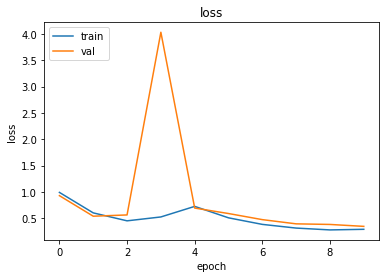

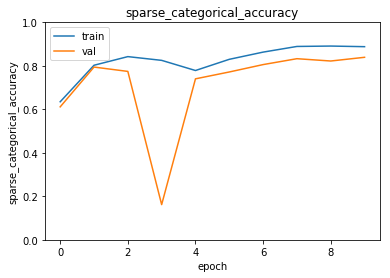

In [15]:
def plot_history(history, key='loss', ylim=None):
    """Plot key vs epochs using keras history"""
    # summarize history for accuracy
    plt.figure()
    plt.plot(history[key])
    plt.plot(history['val_{}'.format(key)])
    plt.title(key)
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.show()

# uncomment this line to load the history of the precomputed model
#history_gmwm = pickle.load(open("data/precomputed_models/model_gmwm.pickle", "rb"))
plot_history(history_gmwm, key='loss')
plot_history(history_gmwm, key='sparse_categorical_accuracy', ylim=(0,1))

## Evaluate model
Evaluation on whole slide histological image
- If it fits in GPU memory, can predict entire image at once, otherwise need to cut image in small patches and predict those (tiled prediction)
    - Patches need to slightly overlap due to the smaller output size of the network
- Re-create model with desired input size and load saved weights

In [16]:
# recreate unet model with larger input size
input_shape = (1020,1020,1)
model_name = 'models/model_gmwm.hdf5' 
# uncomment this line to evaluate the precomputed model
#model_name = 'data/precomputed_models/model_gmwm.hdf5'
# ensure that this is a valid input size
print('Possible input/output sizes of model are:', suggest_input_sizes(model, input_shape[0])) 

input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor)
eval_model.load_weights(model_name)

print("For input shape {} the output shape is {}".format(eval_model.input_shape, eval_model.output_shape)) 

Possible input/output sizes of model are: [(1004.0, 820.0), (1020.0, 836.0), (1036.0, 852.0)]


/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


For input shape (None, 1020, 1020, 1) the output shape is (None, 836, 836, 3)


In [17]:
# functions for creating overlapping patches and writing results back in large image
def create_grid(img, spacing):
    """Calculate evenly spaced grid over image
    Args:
        img (np.ndarray): image
        spacing (int): distance between grid points
    Returns:
        (list): list of tuples denoting the coordinate of each grid point
    """
    xx, yy = np.meshgrid(range(spacing//2, img.shape[0], spacing), range(spacing//2, img.shape[1], spacing))
    return np.array((xx.ravel(), yy.ravel())).T

def sample_from_coords(img, coords, patch_shape, pad=0):
    """Sample patches from coords
    Args:
        img (np.ndarray): image
        coords (list): list of tuples denoting the center coordinate of each patch
        patch_shape (tuple): size of patches that should be sampled
        pad (int): padding value that is added if patches exceed image size
    """
    # pad image with padding value to make cropping easier
    pad_value = max(patch_shape)
    img_padded = np.zeros(np.array(img.shape)+np.array([pad_value*2, pad_value*2]))
    img_padded[pad_value:pad_value+img.shape[0],pad_value:pad_value+img.shape[1]] = img

    crops = []
    offset = np.array(patch_shape)//2
    for coord in coords:
        coord = np.array(coord)
        # coord is center point of crop, coord-offset is upper right corner of crop in img,
        # coord-offset+pad_value is upper left corner in img_padded
        ul = coord - offset + pad_value
        crop = img_padded[ul[0]:ul[0]+patch_shape[0],ul[1]:ul[1]+patch_shape[1]]
        crops.append(crop)
    return crops

def create_image_from_patches(patches, coords, shape):
    """Put predicted patches back in large image
    Args:
        patches (np.ndarray): shape (num_patches, h, w, num_classes)
        coords (list): each coordinate is a 2-tuple denoting the center coordinate of each patch in the original image
        shape (tuple): shape of the original image
    Returns:
        (np.ndarray): prediction image with shape `shape`
    """
    res = np.zeros(shape, dtype=np.uint8)
    offset = np.array(patches.shape[1:3])//2
    for i, coord in enumerate(coords):
        # coord is center of patch
        # coord - offset is upper left corner
        ul = coord - offset
        # ul + patches.shape[1:3] is lower right corner
        # adjust, if is outside of image shape
        lr = np.min([ul + np.array(patches.shape[1:3]), np.array(shape)], axis=0)
        res[ul[0]:lr[0],ul[1]:lr[1]] = np.argmax(patches[i,0:lr[0]-ul[0],0:lr[1]-ul[1]], axis=2)
    return res

Text(0.5, 0.98, 'extracted patches')

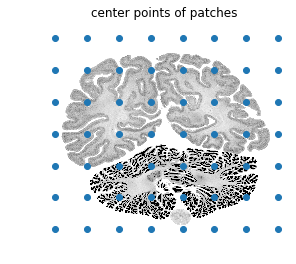

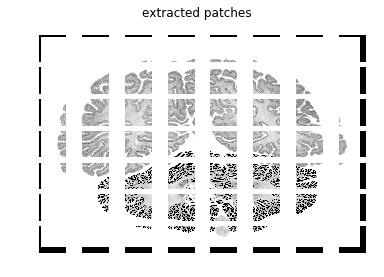

In [18]:
# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_gmwm_fname.format(test_sections[4]))

# create slightly overlapping patches from whole slide section
grid = create_grid(X_test, spacing=eval_model.output_shape[1])
patches = sample_from_coords(X_test, grid, patch_shape=eval_model.input_shape[1:3])

# plot grid on image
fig = plt.figure()
plt.imshow(X_test, cmap='gray')
plt.plot(grid[:,1], grid[:,0], 'o')
plt.axis('off')
plt.title('center points of patches')

# plot patches
fig, axes = plt.subplots(7,8)
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')
    ax.imshow(patches[i], cmap='gray')
plt.suptitle('extracted patches')

In [19]:
# predict patches
patches_to_predict = np.expand_dims(patches,3)
predicted_patches = eval_model.predict_generator(datagen.flow(patches_to_predict, batch_size=1, shuffle=False), steps=len(patches_to_predict))

# create predicted image from patches
Z_test = create_image_from_patches(predicted_patches, grid, X_test.shape)

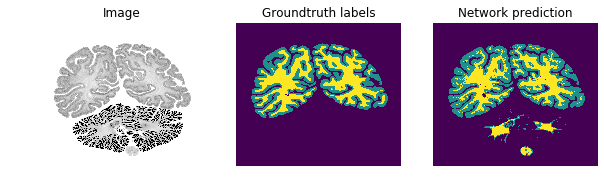

In [21]:
# uncomment this line to view the prediction of the precomputed model
#Z_test = imageio.imread("data/precomputed_models/model_gmwm_prediction.png")

# show results
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(Y_test)
axes[1].set_title("Groundtruth labels")
axes[2].imshow(Z_test)
axes[2].set_title("Network prediction")
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')

Performance is quite good. However, parts of the Cerebellum are classified as white matter. To fix this, the receptive field of the model needs to be larger, to allow the network to locate these pieces of white matter correctly

**Ideas for improving performance**:
- train for longer, decay learning rate
- increase number of training patches (currently only 500)
- use data augmentation
- input low resolution context data as second input (would help with cerebellum misclassification)

# V1 segmentation

## Classes V1/BG 
Apply the same network architecture used for gm/wm segmentation to the task of segmenting V1.
Define as two class classification problem: V1 and background.

### Load precomputed train/val datasets
The patches were sampled in such a way, that both classes are represented equally in the dataset

Text(0.5, 0.98, 'Example train patches')

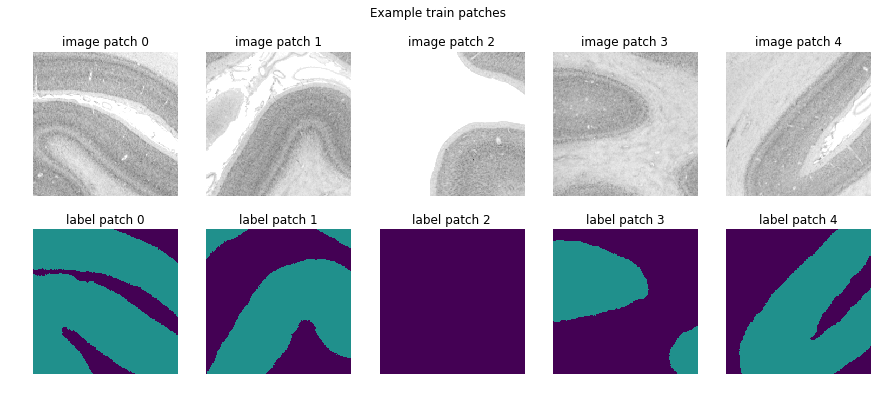

In [22]:
# load precomputed train patches
X_train, Y_train = load_dataset('train_v1.npz')
X_val, Y_val = load_dataset('val_v1.npz')

# visualize image and label patches
fig = plot_dataset(X_train, Y_train, num=5, vmax_y=2)
fig.suptitle("Example train patches")

### Train model

In [44]:
# create network architecture
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor, num_classes=2)  # have two classes now: V1 and background

# parameters for training
lr = 0.01
epochs = 10
batch_size = 24
model_name = 'models/model_v1.hdf5'

# train model
history_v1, datagen = train(model, (X_train, Y_train), (X_val, Y_val), 
                              lr=lr, epochs=epochs, batch_size=batch_size, 
                              model_name=model_name)

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


Epoch 1/10
 - 11s - loss: 0.5649 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.4208 - val_sparse_categorical_accuracy: 0.8162
Epoch 2/10
 - 11s - loss: 0.3927 - sparse_categorical_accuracy: 0.8428 - val_loss: 0.4332 - val_sparse_categorical_accuracy: 0.7634
Epoch 3/10
 - 10s - loss: 0.3529 - sparse_categorical_accuracy: 0.8482 - val_loss: 0.4452 - val_sparse_categorical_accuracy: 0.7515
Epoch 4/10
 - 11s - loss: 0.3144 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.3400 - val_sparse_categorical_accuracy: 0.8501
Epoch 5/10
 - 10s - loss: 0.3010 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.3450 - val_sparse_categorical_accuracy: 0.8474
Epoch 6/10
 - 10s - loss: 0.3257 - sparse_categorical_accuracy: 0.8602 - val_loss: 0.3478 - val_sparse_categorical_accuracy: 0.8515
Epoch 7/10
 - 10s - loss: 0.2685 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.3494 - val_sparse_categorical_accuracy: 0.8539
Epoch 8/10
 - 10s - loss: 0.2813 - sparse_categorical_accuracy: 0.8853 - val

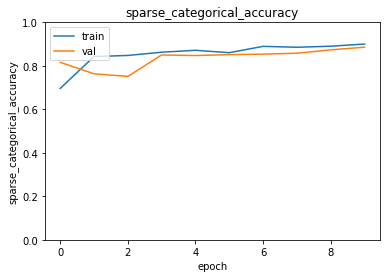

In [23]:
# uncomment this line to view the history of the precomputed model
#history_v1 = pickle.load(open("data/precomputed_models/model_v1.pickle", "rb"))

plot_history(history_v1, key='sparse_categorical_accuracy', ylim=(0,1))

### Evaluate model
The accuracy of the model during training looks ok, but how do the actual predictions look like?

In [24]:
# function for patch-wise evaluation
def predict_image(X, model, weights, datagen):
    """Predict image X with model"""
    model.load_weights(weights)
    # create slightly overlapping patches from whole slide section
    grid = create_grid(X, spacing=model.output_shape[1])
    patches = sample_from_coords(X, grid, patch_shape=model.input_shape[1:3])

    # predict patches
    patches_to_predict = np.expand_dims(patches,3)
    predicted_patches = model.predict_generator(datagen.flow(patches_to_predict, batch_size=1, shuffle=False), steps=len(patches_to_predict))

    # create predicted image from patches
    return create_image_from_patches(predicted_patches, grid, X.shape)

In [28]:
# recreate unet model with larger input size
input_shape = (1020,1020,1)
input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor, num_classes=2)

# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_v1_fname.format(test_sections[4]))

# predict image
model_name = 'models/model_v1.hdf5'
# uncomment this line to evaluate the precomputed model
#model_name = 'data/precomputed_models/model_v1.hdf5'
Z_test = predict_image(X_test, eval_model, model_name, datagen)

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


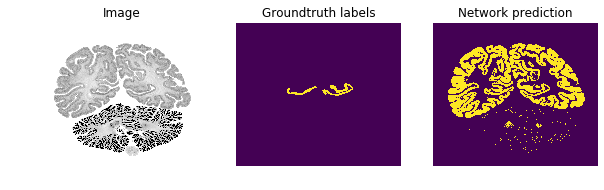

In [29]:
# uncomment this line to view the prediction of the precomputed model
#Z_test = imageio.imread("data/precomputed_models/model_v1_prediction.png")

# show results
fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(Y_test)
axes[1].set_title("Groundtruth labels")
axes[2].imshow(Z_test)
axes[2].set_title("Network prediction")
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')

Instead of V1 segmentation, model has learned cortex segmentation! 
Possible reasons for this:
- Compared to white matter and background, V1 looks similar to other cortex
- The model sees an even distribution of samples from V1 and other samples. But other samples contain mostly background, and not cortex or white matter. Thus, model learns to segment any cortex it sees as V1

Solution:
- Separate background class into distinct components: other cortex, white matter, and background
- Train network on four class segmentation problem: V1, other cortex, white matter, and background
- Evenly sample from all four classes


## Classes V1/Cor/WM/BG

### Load precomputed datasets

Text(0.5, 0.98, 'Example train patches')

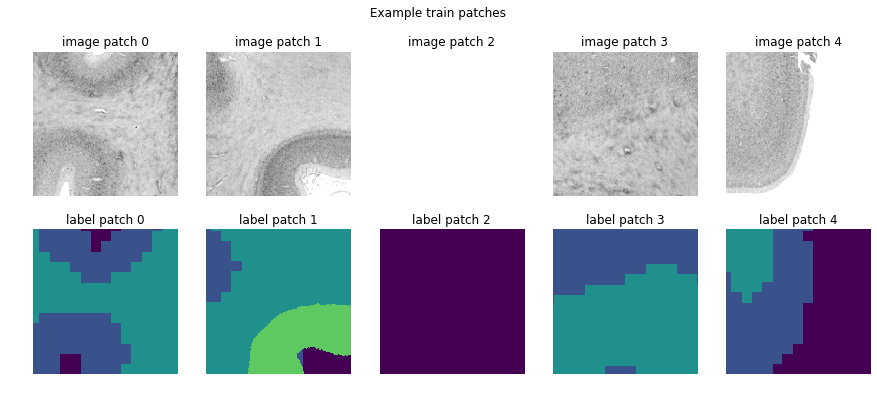

In [30]:
# load precomputed train patches
X_train, Y_train = load_dataset('train_v1gmwm.npz')
X_val, Y_val = load_dataset('val_v1gmwm.npz')

# visualize image and label patches
fig = plot_dataset(X_val, Y_val, num=5, vmax_y=4)
fig.suptitle("Example train patches")

### Train model

In [57]:
# create network architecture
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor, num_classes=4)  # four classes: V1, other cortex, white matter, and background

# parameters for training
lr = 0.01
epochs = 10
batch_size = 24
model_name = 'models/model_v1gmwm_epoch10.hdf5'

# train model
history_v1, datagen = train(model, (X_train, Y_train), (X_val, Y_val), 
                              lr=lr, epochs=epochs, batch_size=batch_size, 
                              model_name=model_name)

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


Epoch 1/10
 - 12s - loss: 1.2371 - sparse_categorical_accuracy: 0.4439 - val_loss: 0.8942 - val_sparse_categorical_accuracy: 0.5761
Epoch 2/10
 - 11s - loss: 0.9765 - sparse_categorical_accuracy: 0.5742 - val_loss: 0.8013 - val_sparse_categorical_accuracy: 0.6077
Epoch 3/10
 - 11s - loss: 0.7716 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.7836 - val_sparse_categorical_accuracy: 0.6130
Epoch 4/10
 - 11s - loss: 0.7255 - sparse_categorical_accuracy: 0.6603 - val_loss: 0.9725 - val_sparse_categorical_accuracy: 0.5844
Epoch 5/10
 - 11s - loss: 0.7324 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.6357
Epoch 6/10
 - 11s - loss: 0.6656 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.6619
Epoch 7/10
 - 11s - loss: 0.6402 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.6849 - val_sparse_categorical_accuracy: 0.7587
Epoch 8/10
 - 11s - loss: 0.6355 - sparse_categorical_accuracy: 0.6872 - val

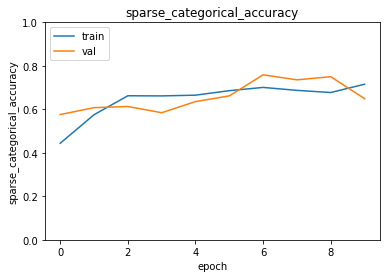

In [31]:
# uncomment this line to view the history of the precomputed model
#history_v1 = pickle.load(open("data/precomputed_models/model_v1gmwm_epoch10.pickle", "rb"))

plot_history(history_v1, key='sparse_categorical_accuracy', ylim=(0,1))

Accuracy is still rising after 10 epochs, should continue to train for a bit longer

In [60]:
# parameters for training
lr = 0.01
epochs = 10
batch_size = 24
model_name = 'models/model_v1gmwm_epoch20.hdf5'

# train model
history_v1, datagen = train(model, (X_train, Y_train), (X_val, Y_val), 
                              lr=lr, epochs=epochs, batch_size=batch_size, 
                              model_name=model_name)

Epoch 1/10
 - 12s - loss: 0.6282 - sparse_categorical_accuracy: 0.6954 - val_loss: 0.6131 - val_sparse_categorical_accuracy: 0.7540
Epoch 2/10
 - 11s - loss: 0.6016 - sparse_categorical_accuracy: 0.6980 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.7208
Epoch 3/10
 - 11s - loss: 0.6150 - sparse_categorical_accuracy: 0.6967 - val_loss: 0.6075 - val_sparse_categorical_accuracy: 0.7037
Epoch 4/10
 - 11s - loss: 0.5787 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.5857 - val_sparse_categorical_accuracy: 0.7381
Epoch 5/10
 - 11s - loss: 0.5856 - sparse_categorical_accuracy: 0.7058 - val_loss: 0.6117 - val_sparse_categorical_accuracy: 0.7435
Epoch 6/10
 - 11s - loss: 0.5820 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.6529
Epoch 7/10
 - 11s - loss: 0.5370 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.6644 - val_sparse_categorical_accuracy: 0.7054
Epoch 8/10
 - 11s - loss: 0.6267 - sparse_categorical_accuracy: 0.6862 - val

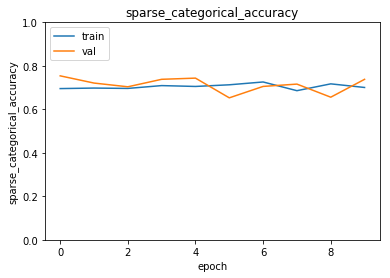

In [33]:
# uncomment this line to view the history of the precomputed model
history_v1 = pickle.load(open("data/precomputed_models/model_v1gmwm_epoch20.pickle", "rb"))

plot_history(history_v1, key='sparse_categorical_accuracy', ylim=(0,1))

Accuracy has flattened, now reduce the learning rate and continue to train for a bit more

In [63]:
# parameters for training
lr = 0.005
epochs = 40
batch_size = 24
model_name = 'models/model_v1gmwm_epoch60.hdf5'

# train model
history_v1, datagen = train(model, (X_train, Y_train), (X_val, Y_val), 
                              lr=lr, epochs=epochs, batch_size=batch_size, 
                              model_name=model_name)

Epoch 1/40
 - 12s - loss: 0.5162 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.5426 - val_sparse_categorical_accuracy: 0.7694
Epoch 2/40
 - 11s - loss: 0.5336 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.5388 - val_sparse_categorical_accuracy: 0.7017
Epoch 3/40
 - 11s - loss: 0.5074 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.5614 - val_sparse_categorical_accuracy: 0.6648
Epoch 4/40
 - 11s - loss: 0.4816 - sparse_categorical_accuracy: 0.7549 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.7006
Epoch 5/40
 - 11s - loss: 0.5092 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6315
Epoch 6/40
 - 11s - loss: 0.4973 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.5741 - val_sparse_categorical_accuracy: 0.7620
Epoch 7/40
 - 11s - loss: 0.4632 - sparse_categorical_accuracy: 0.7635 - val_loss: 0.4910 - val_sparse_categorical_accuracy: 0.7359
Epoch 8/40
 - 11s - loss: 0.4899 - sparse_categorical_accuracy: 0.7558 - val

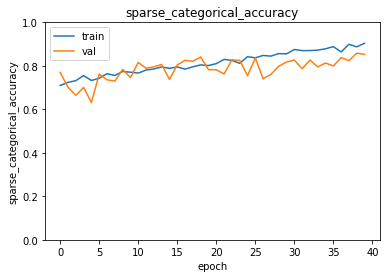

In [34]:
# uncomment this line to view the history of the precomputed model
history_v1 = pickle.load(open("data/precomputed_models/model_v1gmwm_epoch60.pickle", "rb"))

plot_history(history_v1, key='sparse_categorical_accuracy', ylim=(0,1))

### Evaluate model
Evaluate models saved at epochs 10, 20, and 60

In [35]:
# recreate unet model with larger input size
input_shape = (1020,1020,1)
input_tensor = Input(shape=input_shape)
eval_model = u_net(input_tensor, num_classes=4)

# load image to predict
X_test = imageio.imread(sections_fname.format(test_sections[4]))
Y_test = imageio.imread(masks_v1_fname.format(test_sections[4]))

# predict image with model save from epoch 10 and 50
model_name = 'models/model_v1gmwm_epoch10.hdf5'
#model_name = 'data/precomputed_models/model_v1gmwm_epoch10.hdf5'
Z_test1 = predict_image(X_test, eval_model, model_name, datagen)

model_name = 'models/model_v1gmwm_epoch20.hdf5'
#model_name = 'data/precomputed_models/model_v1gmwm_epoch20.hdf5'
Z_test2 = predict_image(X_test, eval_model, model_name, datagen)

model_name = 'models/model_v1gmwm_epoch60.hdf5'
#model_name = 'data/precomputed_models/model_v1gmwm_epoch60.hdf5'
Z_test3 = predict_image(X_test, eval_model, model_name, datagen)

imageio.imsave("data/precomputed_models/model_v1gmwm_epoch10_prediction.png", Z_test1)
imageio.imsave("data/precomputed_models/model_v1gmwm_epoch20_prediction.png", Z_test2)
imageio.imsave("data/precomputed_models/model_v1gmwm_epoch60_prediction.png", Z_test3)

/home/hspitzer/.conda/envs/envDL4HBM/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ou...)`


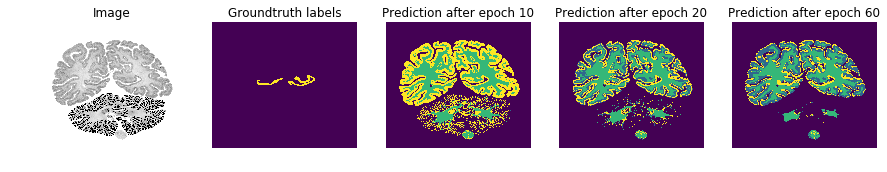

In [36]:
# uncomment these lines to view the prediction of the precomputed model
#Z_test1 = imageio.imread("data/precomputed_models/model_v1gmwm_epoch10_prediction.png")
#Z_test2 = imageio.imread("data/precomputed_models/model_v1gmwm_epoch20_prediction.png")
#Z_test3 = imageio.imread("data/precomputed_models/model_v1gmwm_epoch60_prediction.png")

# show results
fig, axes = plt.subplots(1,5, figsize=(15,5), sharex=True, sharey=True)
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title("Image")
axes[1].imshow(Y_test)
axes[1].set_title("Groundtruth labels")
axes[2].imshow(Z_test1)
axes[2].set_title("Prediction after epoch 10")
axes[3].imshow(Z_test2)
axes[3].set_title("Prediction after epoch 20")
axes[4].imshow(Z_test3)
axes[4].set_title("Prediction after epoch 60")
for i,ax in enumerate(axes.T.flatten()):
    ax.axis('off')

V1 Segmentation looks good after 60 epochs! Model clearly got the correct idea.

- Model needs to train longer training than gm/wm model (task is more difficult)
- Even distribution of V1, cortex, white matter, and background in the training dataset was necessary

The resulting segmentation is not perfect, need more time, and data to get even better results.
Christian Schiffer is going to present our newest approaches for accurate and fast segmentation of cytoarchitectonic areas. If interested, visit **Poster 1535** "Deep Learning speeds up gapless Cytoarchitectonic Mapping in the Human Brain" on Tuesday!
